# ML algorithm to assess improvement after treatment

In [1]:
import warnings
warnings.filterwarnings('ignore')
%config Completer.use_jedi = False

import glob
import numpy as np
import pandas as pd

import scipy
import nilearn
import nilearn.plotting
import nilearn.input_data
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
import xgboost as xg
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
#import shap
from sklearn.model_selection import permutation_test_score


from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV

In [2]:
# load PCL4 data
# sex: 0 = male, 1 = female
df_pcl = pd.read_csv('cpt_pclData.csv')
df_pcl.head()

,scr_id,group,treatment,age,sex,pre_pcl4_score,post_pcl4_score,delta_pcl4_score
0,CPT2001,PTSDCOMB,CPT,30,1,70.0,74.0,4.0
1,CPT2002,PTSDCOMB,CPT,39,0,71.0,31.0,-40.0
2,CPT2005,PTSDCOMB,CPT,29,0,62.0,40.0,-22.0
3,CPT2013,PTSDCOMB,CPT,32,0,45.0,68.0,23.0
4,CPT2017,PTSDCOMB,CPT,30,0,53.0,55.0,2.0


In [3]:
# remove CPT and add sub- to the dataframe, to align with BIDS
for i in df_pcl.iterrows():
    sub = i[1].scr_id.split('CPT')
    sub = 'sub-' + sub[1]
    df_pcl.at[i[0], 'scr_id'] = sub

In [4]:
df_pcl.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43 entries, 0 to 42
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   scr_id            43 non-null     object 
 1   group             43 non-null     object 
 2   treatment         43 non-null     object 
 3   age               43 non-null     int64  
 4   sex               43 non-null     int64  
 5   pre_pcl4_score    41 non-null     float64
 6   post_pcl4_score   41 non-null     float64
 7   delta_pcl4_score  41 non-null     float64
dtypes: float64(3), int64(2), object(3)
memory usage: 2.8+ KB


In [5]:
# add responders / non responders to the data
responder = []
for i in np.arange(len(df_pcl)):
    delta = df_pcl.at[i, 'delta_pcl4_score']
    if delta<=-10:
        responder.append('yes')
    else:
        responder.append('no')
df_pcl['responder'] = responder

In [6]:
df_pcl

,scr_id,group,treatment,age,sex,pre_pcl4_score,post_pcl4_score,delta_pcl4_score,responder
0,sub-2001,PTSDCOMB,CPT,30,1,70.0,74.0,4.0,no
1,sub-2002,PTSDCOMB,CPT,39,0,71.0,31.0,-40.0,yes
2,sub-2005,PTSDCOMB,CPT,29,0,62.0,40.0,-22.0,yes
3,sub-2013,PTSDCOMB,CPT,32,0,45.0,68.0,23.0,no
4,sub-2017,PTSDCOMB,CPT,30,0,53.0,55.0,2.0,no
5,sub-2027,PTSDCOMB,CPT,39,0,57.0,32.0,-25.0,yes
6,sub-2028,PTSDCOMB,CPT,40,0,48.0,31.0,-17.0,yes
7,sub-2032,PTSDCOMB,CPT,23,0,50.0,17.0,-33.0,yes
8,sub-2038,PTSDCOMB,CPT,37,0,66.0,62.0,-4.0,no
9,sub-2042,PTSDCOMB,CPT,30,0,70.0,76.0,6.0,no


<AxesSubplot:xlabel='delta_pcl4_score', ylabel='Count'>

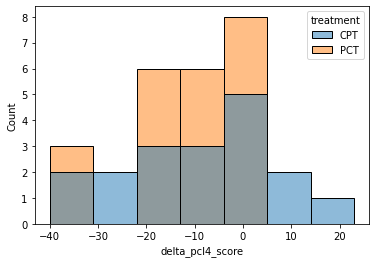

In [7]:
sns.histplot(x='delta_pcl4_score', hue='treatment', data=df_pcl)

In [8]:
# remove nans
df_pcl = df_pcl.dropna()
df_pcl

,scr_id,group,treatment,age,sex,pre_pcl4_score,post_pcl4_score,delta_pcl4_score,responder
0,sub-2001,PTSDCOMB,CPT,30,1,70.0,74.0,4.0,no
1,sub-2002,PTSDCOMB,CPT,39,0,71.0,31.0,-40.0,yes
2,sub-2005,PTSDCOMB,CPT,29,0,62.0,40.0,-22.0,yes
3,sub-2013,PTSDCOMB,CPT,32,0,45.0,68.0,23.0,no
4,sub-2017,PTSDCOMB,CPT,30,0,53.0,55.0,2.0,no
5,sub-2027,PTSDCOMB,CPT,39,0,57.0,32.0,-25.0,yes
6,sub-2028,PTSDCOMB,CPT,40,0,48.0,31.0,-17.0,yes
7,sub-2032,PTSDCOMB,CPT,23,0,50.0,17.0,-33.0,yes
8,sub-2038,PTSDCOMB,CPT,37,0,66.0,62.0,-4.0,no
9,sub-2042,PTSDCOMB,CPT,30,0,70.0,76.0,6.0,no


In [9]:
respond_list = list(df_pcl['scr_id'][df_pcl['responder']=='yes'])
resp_list = []
for subject in respond_list:
    
    sub = subject.split('sub-')[1]
    resp_list.append(sub)


nonrespond_list = list(df_pcl['scr_id'][df_pcl['responder']=='no'])
non_list = []
for subject in nonrespond_list:
    
    sub = subject.split('sub-')[1]
    non_list.append(sub)


In [10]:
resp_func = ['/gpfs/gibbs/pi/levy_ifat/Or/Chadi_Data/results/modelfit/_subject_id_%s/modelestimate/results/zstat1.nii.gz'% (sub) for sub in resp_list]
nonResp_func = ['/gpfs/gibbs/pi/levy_ifat/Or/Chadi_Data/results/modelfit/_subject_id_%s/modelestimate/results/zstat1.nii.gz'% (sub) for sub in non_list]

# now lets grab trauma vs. neutral

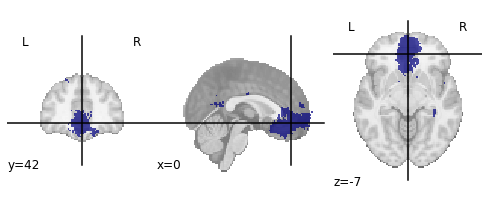

In [12]:
# mask VMPFC
mask_file = '/gpfs/gibbs/pi/levy_ifat/Or/ROI/vmpfc_association-test_z_FDR_0.01.nii.gz'
mask_file = nilearn.image.math_img("a>=3", a=mask_file)
%matplotlib inline
nilearn.plotting.plot_roi(mask_file)
masker = nilearn.input_data.NiftiMasker(mask_img=mask_file, 
                               smoothing_fwhm=None, standardize=True, 
                                        detrend=False, verbose=0)

In [13]:
responders = []
for func in resp_func:
    print(f'Running {func}')
    beta = masker.fit_transform(func)
    responders.append(beta)

nonResponders = []
for func in nonResp_func:
    print(f'Running {func}')
    beta = masker.fit_transform(func)
    nonResponders.append(beta)

respArr = np.array(responders)
respArr_reshape= np.array(respArr).reshape(respArr.shape[0], respArr.shape[2])
respArr_reshape.shape


nonArr = np.array(nonResponders)
nonArr_reshape= np.array(nonArr).reshape(nonArr.shape[0], nonArr.shape[2])
nonArr_reshape.shape


## Create condition labels (1 = responder, 0 = non responder)
label1 = [1] * respArr.shape[0]
label2 = [0] * nonArr.shape[0]
condition_label = np.concatenate([label1, label2])
condition_label

X = np.concatenate([respArr, nonArr])
X = X.reshape(X.shape[0], nonArr_reshape.shape[1])
X.shape

Running /gpfs/gibbs/pi/levy_ifat/Or/Chadi_Data/results/modelfit/_subject_id_2002/modelestimate/results/zstat1.nii.gz
Running /gpfs/gibbs/pi/levy_ifat/Or/Chadi_Data/results/modelfit/_subject_id_2005/modelestimate/results/zstat1.nii.gz
Running /gpfs/gibbs/pi/levy_ifat/Or/Chadi_Data/results/modelfit/_subject_id_2027/modelestimate/results/zstat1.nii.gz
Running /gpfs/gibbs/pi/levy_ifat/Or/Chadi_Data/results/modelfit/_subject_id_2028/modelestimate/results/zstat1.nii.gz
Running /gpfs/gibbs/pi/levy_ifat/Or/Chadi_Data/results/modelfit/_subject_id_2032/modelestimate/results/zstat1.nii.gz
Running /gpfs/gibbs/pi/levy_ifat/Or/Chadi_Data/results/modelfit/_subject_id_2044/modelestimate/results/zstat1.nii.gz
Running /gpfs/gibbs/pi/levy_ifat/Or/Chadi_Data/results/modelfit/_subject_id_2045/modelestimate/results/zstat1.nii.gz
Running /gpfs/gibbs/pi/levy_ifat/Or/Chadi_Data/results/modelfit/_subject_id_2052/modelestimate/results/zstat1.nii.gz
Running /gpfs/gibbs/pi/levy_ifat/Or/Chadi_Data/results/modelfit/

(41, 4485)

In [22]:
#from sklearn.model_selection import StratifiedKFold
model = XGBClassifier(n_jobs=12, 
                      random_state=None, booster = 'dart')

## Here we use stratified K-fold with shuffling to generate different shuffling of leave one subject out
cv = StratifiedKFold(n_splits=18, shuffle=True) # running for each subject


In [23]:
scores = cross_val_score(model,
                            X,
                            y=condition_label,
                            cv=cv,
                            groups=condition_label,
                            scoring= "roc_auc",
                            n_jobs=5, # set number of CPUs
                            #verbose = 5 # set some details of the activity 
                            )

In [24]:
print(scores)
print(np.mean(scores))

[1.  0.  0.5 1.  0.  1.  0.  1.  0.  1.  0.  1.  1.  0.  0.  1.  1.  1. ]
0.5833333333333334


In [ ]:
n_iter = 1000
rand_score = []
for i in range(n_iter):
    print(f' Running {i+1} iteration')
    mean_scores = []
    scores = cross_val_score(model,
                            X,
                            y=condition_label,
                            cv=cv,
                            groups=condition_label,
                            scoring= "roc_auc",#"f1",#"accuracy",
                            n_jobs=12, # set number of CPUs
                            #verbose = 5 # set some details of the activity 
                            )
    mean_scores.append(scores.mean())
    rand_score.append(mean_scores)

 Running 1 iteration
 Running 2 iteration
 Running 3 iteration
 Running 4 iteration
 Running 5 iteration
 Running 6 iteration
 Running 7 iteration
 Running 8 iteration
 Running 9 iteration
 Running 10 iteration
 Running 11 iteration
 Running 12 iteration
 Running 13 iteration
 Running 14 iteration
 Running 15 iteration
 Running 16 iteration
 Running 17 iteration
 Running 18 iteration
 Running 19 iteration
 Running 20 iteration
 Running 21 iteration
 Running 22 iteration
 Running 23 iteration
 Running 24 iteration
 Running 25 iteration
 Running 26 iteration
 Running 27 iteration
 Running 28 iteration
 Running 29 iteration
 Running 30 iteration
 Running 31 iteration
 Running 32 iteration
 Running 33 iteration
 Running 34 iteration
 Running 35 iteration
 Running 36 iteration
 Running 37 iteration
 Running 38 iteration
 Running 39 iteration
 Running 40 iteration
 Running 41 iteration
 Running 42 iteration
 Running 43 iteration
 Running 44 iteration
 Running 45 iteration
 Running 46 iterati

### Plotting area under ROC curve ditribution and printing average and standard deviation of the distribution

Area under curve: 0.54 (+/- 0.15)
95% CI is [0.39958333 0.68333333]


<AxesSubplot:ylabel='Density'>

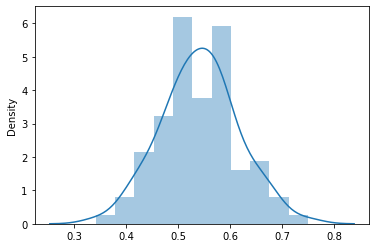

In [45]:
rand_score = np.array(rand_score)
print("Area under curve: %0.2f (+/- %0.2f)" % (np.mean(rand_score), np.std(rand_score) * 2))
print(f'95% CI is {np.quantile(rand_score, [0.025, 0.975])}')
sns.distplot(rand_score)

Area under curve: 0.32 (+/- 0.15)
95% CI is [0.18735119 0.46428571]


<AxesSubplot:ylabel='Density'>

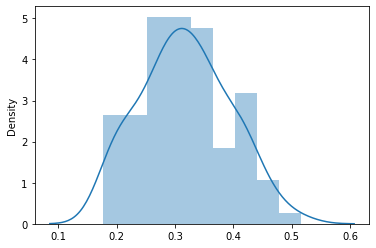

In [17]:
rand_score = np.array(rand_score)
print("Area under curve: %0.2f (+/- %0.2f)" % (np.mean(rand_score), np.std(rand_score) * 2))
print(f'95% CI is {np.quantile(rand_score, [0.025, 0.975])}')
sns.distplot(rand_score)

In [18]:
# use scikit learn permutation 
score_rand, perm_scores_rand, pvalue_rand = permutation_test_score(
    model, X, condition_label, scoring="roc_auc", cv=cv, n_jobs=10, verbose=2,
    n_permutations=50)

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed: 12.1min
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed: 25.1min finished


In [21]:
perm_scores_rand

array([0.725     , 0.65      , 0.675     , 0.5       , 0.36666667,
       0.43333333, 0.41666667, 0.3       , 0.59166667, 0.4       ,
       0.51666667, 0.675     , 0.55833333, 0.38333333, 0.28333333,
       0.5       , 0.475     , 0.575     , 0.3       , 0.4       ,
       0.725     , 0.375     , 0.48333333, 0.325     , 0.675     ,
       0.39166667, 0.43333333, 0.5       , 0.45833333, 0.30833333,
       0.35      , 0.49166667, 0.625     , 0.675     , 0.29166667,
       0.23333333, 0.4       , 0.39166667, 0.66666667, 0.54166667,
       0.55833333, 0.475     , 0.7       , 0.50833333, 0.45      ,
       0.5       , 0.78333333, 0.35      , 0.40833333, 0.75833333])